In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*

In [2]:
# Imports
import sys
import math
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

# Data

In [6]:
# Read data
path = '../../../dataset_sim/mpc_forward.csv'
motion = np.genfromtxt(path, delimiter=',', dtype=np.float64)
contacts = np.genfromtxt(path, delimiter=',', usecols=(29, 30, 31, 32), dtype=bool)
print("Motion data has a length of ", len(motion))

Motion data has a length of  3124


In [7]:
motion.shape

(3124, 33)

## Height-Force plots

In [8]:
def get_specific_cmd(dataset, fwd, side, rot):
    if abs(fwd): 
        return np.where(dataset[:, 1] > 0)[0] if fwd > 0 else np.where(dataset[:, 1] < 0)[0]
    if abs(side): 
        return np.where(dataset[:, 2] > 0)[0] if side > 0 else np.where(dataset[:, 2] < 0)[0]
    if abs(rot): 
        return np.where(dataset[:, 3] > 0)[0] if rot > 0 else np.where(dataset[:, 3] < 0)[0]

In [9]:
def get_swinging_motions(dataset, height=1):
    # rf min height (i.e swining motion)
    fl_min_height = np.where(dataset[:, 6] < height)[0]
    fr_min_height = np.where(dataset[:, 9] < height)[0]
    rl_min_height = np.where(dataset[:, 12] < height)[0]
    rr_min_height = np.where(dataset[:, 15] < height)[0]
            
    return fl_min_height,fr_min_height,rl_min_height,rr_min_height

### Footstep IDXs

In [10]:
footsteps_fwd = get_specific_cmd(motion, 1, 0, 0)
footsteps_clock = get_specific_cmd(motion, 0, 0, -1)
footsteps_count = get_specific_cmd(motion, 0, 0, 1)
footsteps_side_right = get_specific_cmd(motion, 0, -1, 0)
footsteps_side_left = get_specific_cmd(motion, 0, 1, 0)

# CoM displacement comparison (state vs t265)

In [11]:
idxs = np.where(np.isclose(motion[:, 1], 0.5))[0]

In [12]:
idxs

array([1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736,
       1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747,
       1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758,
       1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769,
       1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780,
       1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791,
       1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802,
       1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813,
       1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824,
       1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835,
       1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846,
       1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857,
       1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868,
       1869, 1870, 1871, 1872, 1873, 1874, 1875, 18

In [64]:
print("Velocities sent in x, y, and z: ", "\n", set(motion[idxs, 1]), "\n", set(motion[idxs, 2]), "\n", set(motion[idxs, 3]))

Velocities sent in x, y, and z:  
 {0.5} 
 {0.0} 
 {0.0}


In [65]:
odom_displacements = []
state_displacements = []

for x in idxs:
    odom_rot_prev = quaternion_rotation_matrix(motion[x, 38:42])
    odom_rot_curr = quaternion_rotation_matrix(motion[x+1, 38:42])
    
    state_rot_prev = quaternion_rotation_matrix(motion[x, 48:52])
    state_rot_curr = quaternion_rotation_matrix(motion[x+1, 48:52])
    
    odom_yaw_prev = yaw_from_quaternion(motion[x, 38:42])
    odom_yaw_curr = yaw_from_quaternion(motion[x+1, 38:42])
    odom_yaw = odom_yaw_curr - odom_yaw_prev
    
    state_yaw_prev = yaw_from_quaternion(motion[x, 48:52])
    state_yaw_curr = yaw_from_quaternion(motion[x+1, 48:52])
    state_yaw = state_yaw_curr - state_yaw_prev
    
    if np.sign(odom_yaw_prev) != np.sign(odom_yaw_curr) or \
       np.sign(state_yaw_prev) != np.sign(state_yaw_curr):
        print("Angle wrap detected.")
        continue
    
    corrected_odom_pose_prev = motion[x, 35:38] @ odom_rot_prev
    corrected_odom_pose_curr = motion[x+1, 35:38] @ odom_rot_prev
    
    corrected_state_pose_prev = motion[x, 16:19] @ state_rot_prev
    corrected_state_pose_curr = motion[x+1, 16:19] @ state_rot_prev
    
    corrected_odom_displacement = corrected_odom_pose_curr - corrected_odom_pose_prev
    corrected_state_displacement = corrected_state_pose_curr - corrected_state_pose_prev
    
    odom_displacements.append(np.append(corrected_odom_displacement, odom_yaw))
    state_displacements.append(np.append(corrected_state_displacement, state_yaw))
    
odom_displacements = np.array(odom_displacements)
state_displacements = np.array(state_displacements)

Angle wrap detected.
Angle wrap detected.
Angle wrap detected.


In [66]:
# X displacement mean and std
print(f"State mean CoM(x) displacement of {np.mean(state_displacements[:, 0])} with a std of {np.std(state_displacements[:, 0])}")
print(f"State mean CoM(y) displacement of {np.mean(state_displacements[:, 1])} with a std of {np.std(state_displacements[:, 1])}")
print(f"State mean CoM(z) displacement of {np.mean(state_displacements[:, 2])} with a std of {np.std(state_displacements[:, 2])}")
print(f"State mean CoM(yaw) displacement of {np.mean(state_displacements[:, 3])} with a std of {np.std(state_displacements[:, 3])}")

State mean CoM(x) displacement of 0.14495363477644496 with a std of 0.019281461161740048
State mean CoM(y) displacement of -0.004212906960505062 with a std of 0.0043308669111827265
State mean CoM(z) displacement of -0.00036445818580376263 with a std of 0.004631810743875825
State mean CoM(yaw) displacement of -0.00015600606225809198 with a std of 0.015204948102260418


In [67]:
# X displacement mean and std
print(f"Odom mean CoM(x) displacement of {np.mean(odom_displacements[:, 0])} with a std of {np.std(odom_displacements[:, 0])}")
print(f"Odom mean CoM(y) displacement of {np.mean(odom_displacements[:, 1])} with a std of {np.std(odom_displacements[:, 1])}")
print(f"Odom mean CoM(z) displacement of {np.mean(odom_displacements[:, 2])} with a std of {np.std(odom_displacements[:, 2])}")
print(f"Odom mean CoM(yaw) displacement of {np.mean(odom_displacements[:, 3])} with a std of {np.std(odom_displacements[:, 3])}")

Odom mean CoM(x) displacement of 0.11776153238779134 with a std of 0.029409349800705743
Odom mean CoM(y) displacement of 0.00036043647343746214 with a std of 0.0178133291698812
Odom mean CoM(z) displacement of 0.0315376681604353 with a std of 0.012013542990794964
Odom mean CoM(yaw) displacement of -0.0002719868661058071 with a std of 0.015838949621012822


# Dataset Preparation

In [10]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [11]:
def yaw_from_quaternion(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    x = Q[0]
    y = Q[1]
    z = Q[2]
    w = Q[3]
     
    return np.arctan2(2 * (w*z + x*y), 1 - 2 * (y*y + z*z))

In [12]:
def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[3]
    q1 = Q[0]
    q2 = Q[1]
    q3 = Q[2]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

In [19]:
def create_com_dataset(dataset, footsteps, motion=None, debug=False):
    inputs = []
    labels = []
    
    for idx, footstep in enumerate(footsteps):
        if idx > 0:
            # Compute time difference between
            # current and next footsteps
            time_difference = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0])
            
            if time_difference < 0.4 and np.any(dataset[footsteps[idx-1], 1:4]) and np.any(dataset[footsteps[idx], 1:4]):
                fl_moving = contacts[footsteps[idx], 0]
                fr_moving = contacts[footsteps[idx], 1]
                rl_moving = contacts[footsteps[idx], 2]
                rr_moving = contacts[footsteps[idx], 3]
                
                assert fr_moving == rl_moving
                assert rr_moving == fl_moving
                assert fr_moving != fl_moving
                
                # Compute rotation matrices from odometry orientation
                R_prev = quaternion_rotation_matrix(dataset[footsteps[idx-1], 48:52])
                R_curr = quaternion_rotation_matrix(dataset[footsteps[idx], 48:52])

                # Odom base vectors
                prev_base = dataset[footsteps[idx-1], 16:19]
                curr_base = dataset[footsteps[idx], 16:19]

                # Rotate odometry estimation
                rotated_prev_base = prev_base @ R_prev
                rotated_curr_base = curr_base @ R_prev
                base_displacement = rotated_curr_base - rotated_prev_base
                
                prev_yaw = yaw_from_quaternion(dataset[footsteps[idx-1], 48:52])
                curr_yaw = yaw_from_quaternion(dataset[footsteps[idx], 48:52])
                yaw = curr_yaw - prev_yaw
                
                # Handle angle wrap
                if np.sign(prev_yaw) != np.sign(curr_yaw):
                    #print("Angle wrap detected.")
                    continue
                    
                inputs.append(dataset[footsteps[idx-1], 1:55].tolist() +
                              [fl_moving, fr_moving, rl_moving, rr_moving] +
                              dataset[footsteps[idx], 1:4].tolist())
                
                # Labels
                labels.append([base_displacement[0], base_displacement[1], yaw])
                
    return np.array(inputs, dtype=float), np.array(labels, dtype=float)
                
X_motion_fwd_CoM, Y_motion_fwd_CoM = create_com_dataset(motion, footsteps_fwd)
X_motion_clock_CoM, Y_motion_clock_CoM = create_com_dataset(motion, footsteps_clock)
X_motion_count_CoM, Y_motion_count_CoM = create_com_dataset(motion, footsteps_count)
#X_motion_side_left_CoM, Y_motion_side_left_CoM = create_com_dataset(motion, footsteps_side_left)
#X_motion_side_right_CoM, Y_motion_side_right_CoM = create_com_dataset(motion, footsteps_side_right)

# Stack datasets
X_motion_CoM_continuous = np.concatenate((X_motion_fwd_CoM, X_motion_clock_CoM, X_motion_count_CoM))
Y_motion_CoM_continuous = np.concatenate((Y_motion_fwd_CoM, Y_motion_clock_CoM, Y_motion_count_CoM))

#X_motion_CoM_continuous = X_motion_fwd_CoM
#Y_motion_CoM_continuous = Y_motion_fwd_CoM

print(X_motion_CoM_continuous.shape)
print(Y_motion_CoM_continuous.shape)

(4626, 61)
(4626, 3)


In [20]:
%store X_motion_CoM_continuous
%store Y_motion_CoM_continuous

Stored 'X_motion_CoM_continuous' (ndarray)
Stored 'Y_motion_CoM_continuous' (ndarray)


# Velocity Check

In [21]:
set(X_motion_CoM_continuous[:, 0])

{0.0,
 0.10000000149011612,
 0.20000000298023224,
 0.30000001192092896,
 0.4000000059604645,
 0.5,
 0.6000000238418579,
 0.7000000476837158,
 0.8000000715255737}

# FWD CoM displacements

In [22]:
# X displacement mean and std for each velocity
for velocity in np.arange(0.1, 0.8, 0.1):
    idx = np.where(np.isclose(X_motion_CoM_continuous[:, 0], velocity))[0]
    print(f"Velocity {velocity} with {len(idx)} samples")
    print(f"Mean CoM(x) displacement of {np.mean(Y_motion_CoM_continuous[idx, 0])} with a std of {np.std(Y_motion_CoM_continuous[idx, 0])}")
    print(f"Mean CoM(y) displacement of {np.mean(Y_motion_CoM_continuous[idx, 1])} with a std of {np.std(Y_motion_CoM_continuous[idx, 1])}")
    print(f"Mean CoM(yaw) displacement of {np.mean(Y_motion_CoM_continuous[idx, 2])} with a std of {np.std(Y_motion_CoM_continuous[idx, 2])}\n")

Velocity 0.1 with 266 samples
Mean CoM(x) displacement of 0.029043418023301237 with a std of 0.0038402988352100867
Mean CoM(y) displacement of -0.0007757801502111205 with a std of 0.0022179419676447744
Mean CoM(yaw) displacement of 0.00021430374229185314 with a std of 0.024935627566510455

Velocity 0.2 with 232 samples
Mean CoM(x) displacement of 0.05782537736997163 with a std of 0.005518944483271522
Mean CoM(y) displacement of -0.0017786545615455938 with a std of 0.0026439486877430788
Mean CoM(yaw) displacement of 0.0005965903670076176 with a std of 0.027995066095724296

Velocity 0.30000000000000004 with 388 samples
Mean CoM(x) displacement of 0.08666628349112852 with a std of 0.008037758074142925
Mean CoM(y) displacement of -0.00280835750514929 with a std of 0.003026324369363806
Mean CoM(yaw) displacement of -4.2196457373435445e-05 with a std of 0.018572930191161612

Velocity 0.4 with 233 samples
Mean CoM(x) displacement of 0.11553679932936183 with a std of 0.009780265618673198
Mean 

# CK CoM displacement

In [23]:
# X displacement mean and std for each velocity
for velocity in np.arange(0.1, 0.7, 0.1):
    idx = np.where(np.isclose(X_motion_CoM_continuous[:, 2], -velocity))[0]
    print(f"Velocity {velocity} with {len(idx)} samples")
    print(f"Mean CoM(x) displacement of {np.mean(Y_motion_CoM_continuous[idx, 0])} with a std of {np.std(Y_motion_CoM_continuous[idx, 0])}")
    print(f"Mean CoM(y) displacement of {np.mean(Y_motion_CoM_continuous[idx, 1])} with a std of {np.std(Y_motion_CoM_continuous[idx, 1])}")
    print(f"Mean CoM(yaw) displacement of {np.mean(Y_motion_CoM_continuous[idx, 2])} with a std of {np.std(Y_motion_CoM_continuous[idx, 2])}\n")

Velocity 0.1 with 241 samples
Mean CoM(x) displacement of 0.00025801163946501837 with a std of 0.00211926988068666
Mean CoM(y) displacement of 0.00023555819553245717 with a std of 0.00155589215873412
Mean CoM(yaw) displacement of -0.015031783047303232 with a std of 0.004191472236438389

Velocity 0.2 with 205 samples
Mean CoM(x) displacement of 0.000493477807934928 with a std of 0.0019820905722636537
Mean CoM(y) displacement of 0.0006862128671813109 with a std of 0.0018750096328578407
Mean CoM(yaw) displacement of -0.03959080727334828 with a std of 0.006753433190826002

Velocity 0.30000000000000004 with 215 samples
Mean CoM(x) displacement of 0.00039625114109239593 with a std of 0.0023472778437139954
Mean CoM(y) displacement of 0.001008068135495922 with a std of 0.0019737622651469886
Mean CoM(yaw) displacement of -0.06476474148880959 with a std of 0.008251320620531738

Velocity 0.4 with 210 samples
Mean CoM(x) displacement of 0.00043377415545793764 with a std of 0.0023165672184073368
Me

# CCK CoM displacement

In [24]:
# X displacement mean and std for each velocity
for velocity in np.arange(0.1, 0.7, 0.1):
    idx = np.where(np.isclose(X_motion_CoM_continuous[:, 2], velocity))[0]
    print(f"Velocity {velocity} with {len(idx)} samples")
    print(f"Mean CoM(x) displacement of {np.mean(Y_motion_CoM_continuous[idx, 0])} with a std of {np.std(Y_motion_CoM_continuous[idx, 0])}")
    print(f"Mean CoM(y) displacement of {np.mean(Y_motion_CoM_continuous[idx, 1])} with a std of {np.std(Y_motion_CoM_continuous[idx, 1])}")
    print(f"Mean CoM(yaw) displacement of {np.mean(Y_motion_CoM_continuous[idx, 2])} with a std of {np.std(Y_motion_CoM_continuous[idx, 2])}\n")

Velocity 0.1 with 219 samples
Mean CoM(x) displacement of 0.0003173681724122551 with a std of 0.0020450625964605635
Mean CoM(y) displacement of -0.00028867752016168086 with a std of 0.0015949598532395768
Mean CoM(yaw) displacement of 0.02585724516213308 with a std of 0.00717702615108797

Velocity 0.2 with 221 samples
Mean CoM(x) displacement of 0.0005751102634830831 with a std of 0.0021915878723287093
Mean CoM(y) displacement of -0.0006739198406217409 with a std of 0.0018171291306067117
Mean CoM(yaw) displacement of 0.05107768609110817 with a std of 0.008387378762542873

Velocity 0.30000000000000004 with 228 samples
Mean CoM(x) displacement of 0.0006592397905442424 with a std of 0.002519677707850756
Mean CoM(y) displacement of -0.0012548329755954252 with a std of 0.0018958439617409466
Mean CoM(yaw) displacement of 0.07717349508984206 with a std of 0.00865685056049785

Velocity 0.4 with 200 samples
Mean CoM(x) displacement of 0.0006897120224921611 with a std of 0.0026583306091478315
Mea

### Fwd Plot

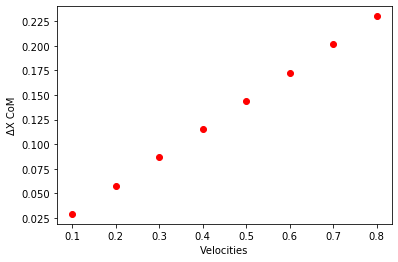

In [25]:
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
         [np.mean(Y_motion_fwd_CoM[np.where(np.isclose(X_motion_fwd_CoM[:, 0], velocity))[0], 0]) for velocity in np.arange(0.1, 0.9, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394X CoM')
plt.show()

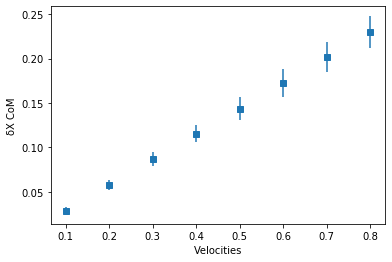

In [26]:
x = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
y = np.array([np.mean(Y_motion_fwd_CoM[np.where(np.isclose(X_motion_fwd_CoM[:, 0], velocity))[0], 0]) for velocity in np.arange(0.1, 0.9, 0.1)])
e = np.array([np.std(Y_motion_fwd_CoM[np.where(np.isclose(X_motion_fwd_CoM[:, 0], velocity))[0], 0]) for velocity in np.arange(0.1, 0.9, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4X CoM')
plt.show()

### Left Plot

In [27]:
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         [np.mean(Y_motion_side_left_CoM[np.where(np.isclose(X_motion_side_left_CoM[:, 1], velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394Y CoM')
plt.show()

NameError: name 'Y_motion_side_left_CoM' is not defined

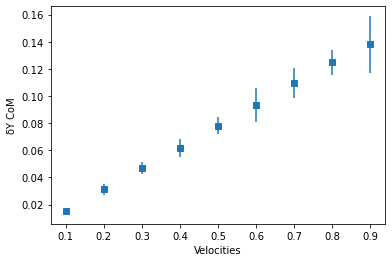

In [19]:
x = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
y = np.array([np.mean(Y_motion_side_left_CoM[np.where(np.isclose(X_motion_side_left_CoM[:, 1], velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)])
e = np.array([np.std(Y_motion_side_left_CoM[np.where(np.isclose(X_motion_side_left_CoM[:, 1], velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4Y CoM')
plt.show()

### Right Plot

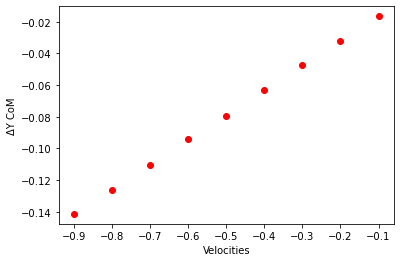

In [31]:
plt.plot([-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9],
         [np.mean(Y_motion_side_right_CoM[np.where(np.isclose(X_motion_side_right_CoM[:, 1], -velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394Y CoM')
plt.show()

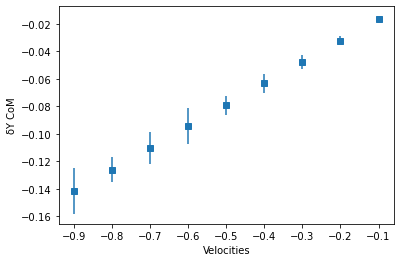

In [32]:
x = np.array([-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9])
y = np.array([np.mean(Y_motion_side_right_CoM[np.where(np.isclose(X_motion_side_right_CoM[:, 1], -velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)])
e = np.array([np.std(Y_motion_side_right_CoM[np.where(np.isclose(X_motion_side_right_CoM[:, 1], -velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4Y CoM')
plt.show()

### Clock Plot

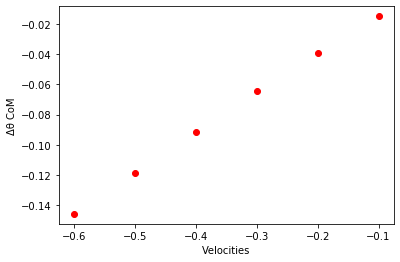

In [28]:
plt.plot([-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9],
         [np.mean(Y_motion_clock_CoM[np.where(np.isclose(X_motion_clock_CoM[:, 2], -velocity))[0], 2]) for velocity in np.arange(0.1, 1.0, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394\u03B8 CoM')
plt.show()

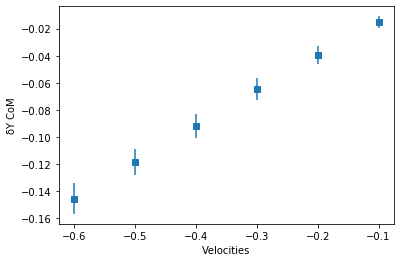

In [29]:
x = np.array([-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9])
y = np.array([np.mean(Y_motion_clock_CoM[np.where(np.isclose(X_motion_clock_CoM[:, 2], -velocity))[0], 2]) for velocity in np.arange(0.1, 1.0, 0.1)])
e = np.array([np.std(Y_motion_clock_CoM[np.where(np.isclose(X_motion_clock_CoM[:, 2], -velocity))[0], 2]) for velocity in np.arange(0.1, 1.0, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4Y CoM')
plt.show()

### Count Plot

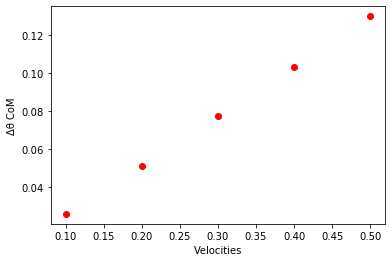

In [30]:
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5],
         [np.mean(Y_motion_count_CoM[np.where(np.isclose(X_motion_count_CoM[:, 2], velocity))[0], 2]) for velocity in np.arange(0.1, 0.6, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394\u03B8 CoM')
plt.show()

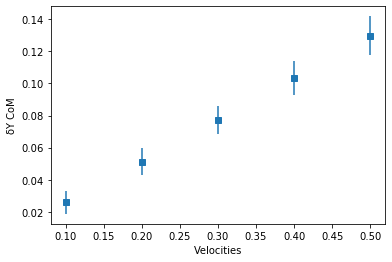

In [31]:
x = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
y = np.array([np.mean(Y_motion_count_CoM[np.where(np.isclose(X_motion_count_CoM[:, 2], velocity))[0], 2]) for velocity in np.arange(0.1, 0.6, 0.1)])
e = np.array([np.std(Y_motion_count_CoM[np.where(np.isclose(X_motion_count_CoM[:, 2], velocity))[0], 2]) for velocity in np.arange(0.1, 0.6, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4Y CoM')
plt.show()

## Forwad Check

In [32]:
print(f"Min displacement: {min(Y_motion_fwd_CoM[:, 0])}. Max displacement: {max(Y_motion_fwd_CoM[:, 0])}")

Min displacement: 0.014050214716398557. Max displacement: 0.28447556778137795


## Clockwise Check

In [33]:
print(f"Min displacement: {min(Y_motion_clock_CoM[:, 2])}. Max displacement: {max(Y_motion_clock_CoM[:, 2])}")

Min displacement: -0.17573920561052958. Max displacement: 0.009805246739182039


## Counter Check

In [35]:
print(f"Min displacement: {min(Y_motion_count_CoM[:, 2])}. Max displacement: {max(Y_motion_count_CoM[:, 2])}")

Min displacement: -0.0031576260081980223. Max displacement: 0.1886456775168024


## Left Check

In [23]:
print(f"Min displacement: {min(Y_motion_side_left_CoM[:, 1])}. Max displacement: {max(Y_motion_side_left_CoM[:, 1])}")

Min displacement: 0.007853730130729542. Max displacement: 0.09715947318711393


## Right Check

In [24]:
print(f"Min displacement: {min(Y_motion_side_right_CoM[:, 1])}. Max displacement: {max(Y_motion_side_right_CoM[:, 1])}")

Min displacement: -0.0944799924815003. Max displacement: -0.010731300881279493
